In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pyomo
from pyomo.environ import *
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, RangeSet
from pyomo.environ import Binary, NonNegativeReals
from pyomo.environ import minimize


# data
df = pd.read_excel('test_data.xlsx')
time_frame = list(df.index)
pv_production_list = df['pv production, kWh'].tolist()  # hourly generation
electrical_consumption_list = df['electrical consumption, kWh'].tolist()  # hourly demand
battery_discharge_cost_list = df['lcos, c/kWh'].tolist()  # constant
sell_price_list = df['electricity selling price, c/kWh'].tolist()  # hourly selling prices
buy_price_list = df['electricity buying price c/kWh'].tolist()  # hourly buying prices

# fixed params
BatteryCapacity = 160  # max battery storage in KWh
BatteryChargeDischargeRateCapacity = 100  # max battery charge discharge rate in KWh
BatteryChargingEfficiency = 0.92  # discharging is lossless
GridMax = 700  # buy/sell limit in KW which is also KWh in this case
InitialBatteryCharge = 0  # battery state at t=0

# model
model = ConcreteModel()

# model variables
model.T = RangeSet(0, len(time_frame)-1)

model.pv_to_consumer = Var(model.T, domain=NonNegativeReals)
model.pv_to_battery = Var(model.T, bounds=(0, BatteryChargeDischargeRateCapacity))
model.pv_to_grid = Var(model.T, domain=NonNegativeReals)

model.battery_to_grid = Var(model.T, bounds=(0, BatteryChargeDischargeRateCapacity))
model.battery_to_consumer = Var(model.T, bounds=(0, BatteryChargeDischargeRateCapacity))

model.grid_to_battery = Var(model.T, bounds=(0, BatteryChargeDischargeRateCapacity))
model.grid_to_consumer = Var(model.T, domain=NonNegativeReals)

model.battery_charge = Var(model.T, bounds=(0, BatteryCapacity))

# objective function
model.obj = Objective(expr=sum((model.grid_to_consumer[t] + model.grid_to_battery[t]) * buy_price_list[t]
                               - (model.pv_to_grid[t] * sell_price_list[t] + model.battery_to_grid[t] * sell_price_list[t])
                               + (model.battery_to_consumer[t] + model.battery_to_grid[t]) * battery_discharge_cost_list[t] for t in model.T), sense=minimize)

# constraints
model.meet_demand = ConstraintList()
for t in model.T:
    model.meet_demand.add(electrical_consumption_list[t]
                          == model.pv_to_consumer[t] + model.grid_to_consumer[t] + model.battery_to_consumer[t])

model.pv_distribution = ConstraintList()
for t in model.T:
    model.pv_distribution.add(pv_production_list[t]
                              == model.pv_to_consumer[t] + model.pv_to_grid[t] + model.pv_to_battery[t])

model.battery_charge_update = ConstraintList()
for t in model.T:
    model.battery_charge_update.add(model.battery_charge[t] <= BatteryCapacity)
    if t == 0:
        model.battery_charge_update.add(model.battery_charge[t] == InitialBatteryCharge)
    else:
        model.battery_charge_update.add(model.battery_charge[t]
                                        == model.battery_charge[t-1] + BatteryChargingEfficiency * (model.pv_to_battery[t-1] + model.grid_to_battery[t-1])
                                         - (model.battery_to_grid[t-1] + model.battery_to_consumer[t-1]))

model.battery_charge_rate_limit = ConstraintList()
for t in model.T:
    model.battery_charge_rate_limit.add(model.pv_to_battery[t] + model.grid_to_battery[t] <= BatteryChargeDischargeRateCapacity)

model.battery_discharge_rate_limit = ConstraintList()
for t in model.T:
    model.battery_discharge_rate_limit.add(model.battery_to_grid[t] + model.battery_to_consumer[t] <= BatteryChargeDischargeRateCapacity)

model.sell_to_grid_limit = ConstraintList()
for t in model.T:
    model.sell_to_grid_limit.add(model.pv_to_grid[t] + model.battery_to_grid[t] <= GridMax)

model.buy_from_grid_limit = ConstraintList()
for t in model.T:
    model.buy_from_grid_limit.add(model.grid_to_consumer[t] + model.grid_to_battery[t] <= GridMax)

solver = solver = SolverFactory('glpk', executable='/opt/homebrew/bin/glpsol')
solver.solve(model, tee=True)

# output
results = {'Time frame': [],
           'PV to consumer': [],
           'PV to grid': [],
           'PV to battery': [],
           'Battery to consumer': [],
           'Battery to grid': [],
           'Grid to consumer (buy)': [],
           'Grid to battery (buy)': [],
           'Battery charge': []}

for t in model.T:
    results['Time frame'].append(t)
    results['PV to consumer'].append(model.pv_to_consumer[t].value)
    results['PV to grid'].append(model.pv_to_grid[t].value)
    results['PV to battery'].append(model.pv_to_battery[t].value)
    results['Battery to consumer'].append(model.battery_to_consumer[t].value)
    results['Battery to grid'].append(model.battery_to_grid[t].value)
    results['Grid to consumer (buy)'].append(model.grid_to_consumer[t].value)
    results['Grid to battery (buy)'].append(model.grid_to_battery[t].value)
    results['Battery charge'].append(model.battery_charge[t].value)

df_results = pd.DataFrame(results)
df_results

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/dw/q0n2236s72b3g6z7q99x5qkh0000gn/T/tmpeaabfh78.glpk.raw
 --wglp /var/folders/dw/q0n2236s72b3g6z7q99x5qkh0000gn/T/tmpk6amlpva.glpk.glp
 --cpxlp /var/folders/dw/q0n2236s72b3g6z7q99x5qkh0000gn/T/tmphvvvbybm.pyomo.lp
Reading problem data from '/var/folders/dw/q0n2236s72b3g6z7q99x5qkh0000gn/T/tmphvvvbybm.pyomo.lp'...
384 rows, 384 columns, 1003 non-zeros
2788 lines were read
Writing problem data to '/var/folders/dw/q0n2236s72b3g6z7q99x5qkh0000gn/T/tmpk6amlpva.glpk.glp'...
2569 lines were written
GLPK Simplex Optimizer 5.0
384 rows, 384 columns, 1003 non-zeros
Preprocessing...
272 rows, 319 columns, 764 non-zeros
Scaling...
 A: min|aij| =  9.200e-01  max|aij| =  1.000e+00  ratio =  1.087e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 272
      0: obj =   2.122796337e+05 inf =   5.585e+02 (5)
      3: obj =   2.163135584e+05 inf =   0.000e+00 (0)


,Time frame,PV to consumer,PV to grid,PV to battery,Battery to consumer,Battery to grid,Grid to consumer (buy),Grid to battery (buy),Battery charge
0,0,0.000000,0.000000,0.000000,0.0,0.0,69.540000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.0,0.0,74.941647,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.0,0.0,83.941647,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.0,0.0,114.641647,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.0,0.0,281.117334,0.000000,0.000000
5,5,28.676310,0.000000,0.000000,0.0,0.0,282.783694,0.000000,0.000000
6,6,130.432680,0.000000,0.000000,0.0,0.0,177.862324,0.000000,0.000000
7,7,289.116110,0.000000,0.000000,0.0,0.0,23.648054,0.000000,0.000000
8,8,426.354320,0.000000,0.000000,0.0,0.0,46.534704,0.000000,0.000000
9,9,0.000000,524.139590,0.000000,0.0,0.0,499.476784,73.913043,0.000000


In [2]:
print(f"Total cost: {model.obj():.2f}")

Total cost: 141215.63


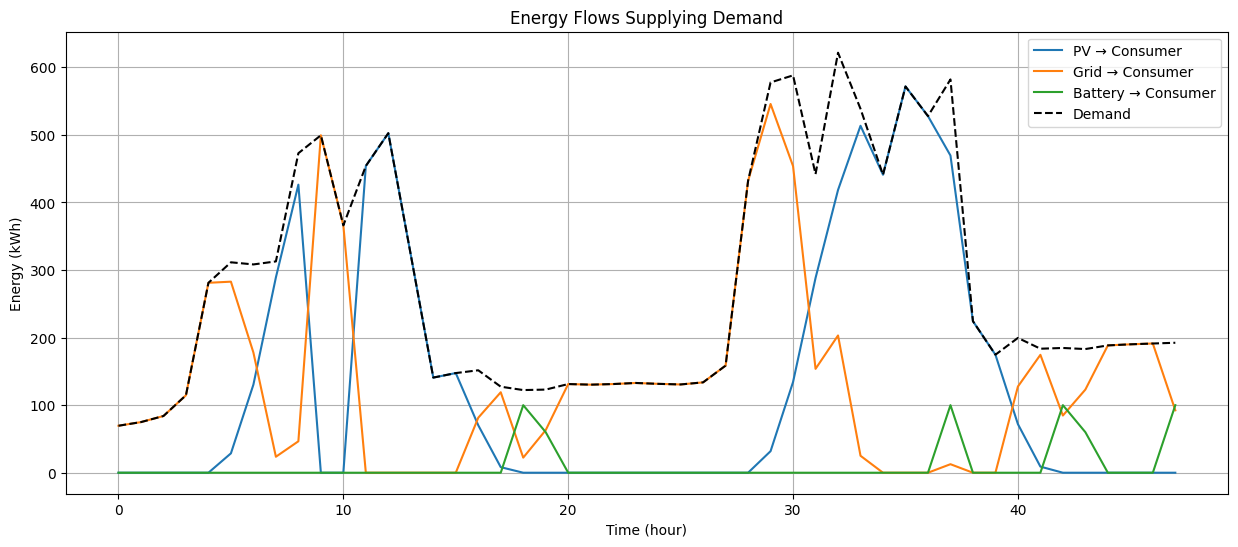

In [4]:
plt.figure(figsize=(15, 6))

plt.plot(df_results['Time frame'], df_results['PV to consumer'], label='PV → Consumer')
plt.plot(df_results['Grid to consumer (buy)'], label='Grid → Consumer')
plt.plot(df_results['Battery to consumer'], label='Battery → Consumer')
plt.plot(df_results['Time frame'], electrical_consumption_list, label='Demand', linestyle='--', color='black')

plt.xlabel('Time (hour)')
plt.ylabel('Energy (kWh)')
plt.title('Energy Flows Supplying Demand')
plt.legend()
plt.grid(True)
plt.show()
